In [ ]:
!pip install datasets

In [ ]:
!pip install torchmetrics

In [ ]:
from datasets import load_dataset

ds = load_dataset("dddraxxx/vis_refcoco_rv", split="refcoco_val")

person standing


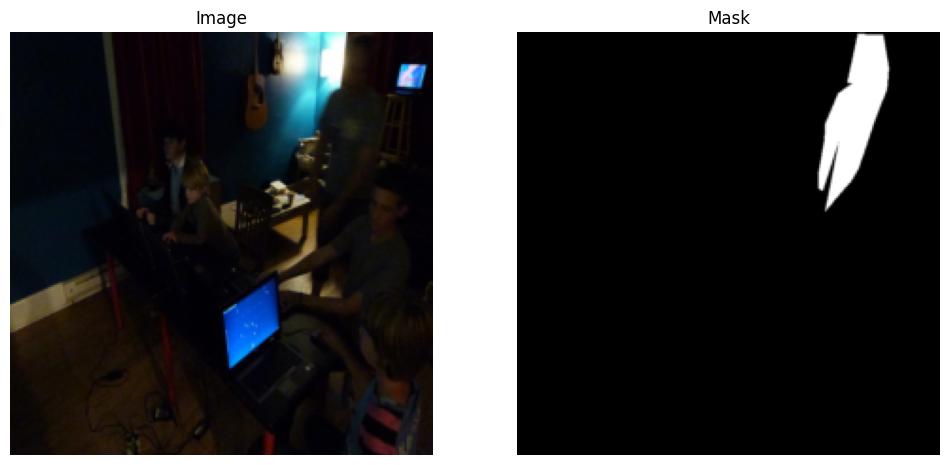

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_data(sample):
    image = sample['image']
    mask = sample['mask']

    image = preprocess(image)
    mask = preprocess(mask)

    expression = sample['sampled_sent']

    return image, mask, expression

image, mask, expression = load_data(ds[0])
print(expression)

image_np = image.permute(1, 2, 0).numpy()
mask_np = mask.numpy().squeeze()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class ReferringDataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        sample = self.ds[idx]

        image = sample['image']
        mask = sample['mask']

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()

        expression = sample['sampled_sent']

        return image, expression, mask

In [ ]:
dataset = ReferringDataset(ds, transform=preprocess)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

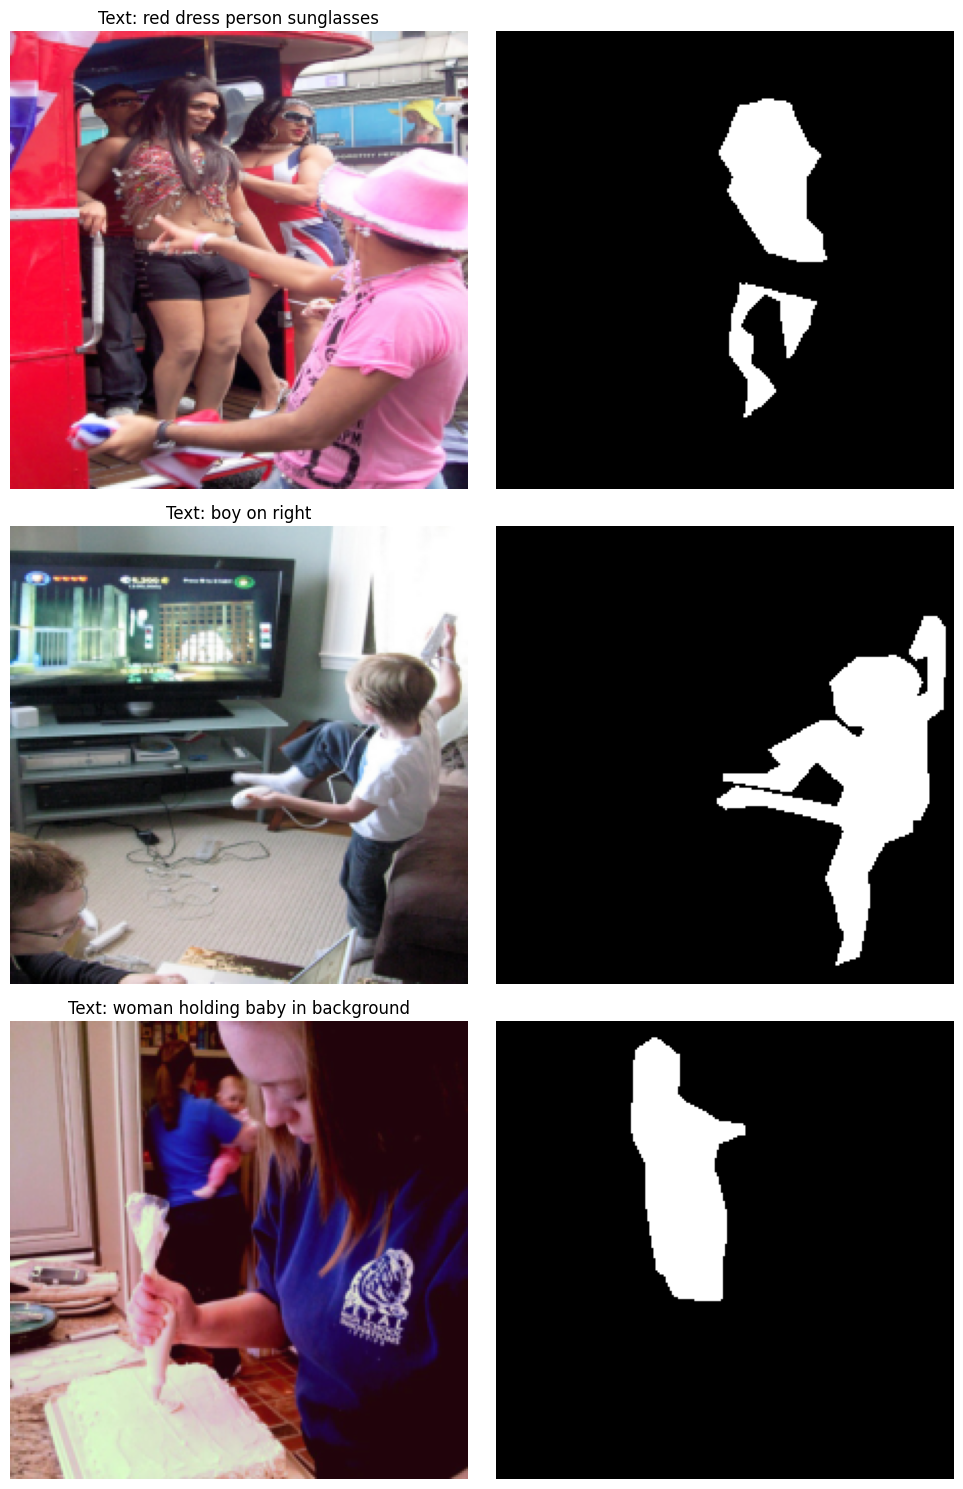

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_batch_from_loader(batch, num_samples):

    images, texts, masks = batch
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        image = np.transpose(images[i], (1, 2, 0))
        mask = masks[i].squeeze()

        image = (image - image.min()) / (image.max() - image.min())

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Text: {texts[i]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

batch = next(iter(train_loader))
plot_batch_from_loader(batch, 3)

In [ ]:
import torch
import torch.nn as nn

from transformers import AutoProcessor, CLIPVisionModelWithProjection
from transformers import AutoTokenizer, CLIPTextModelWithProjection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FiLMModulation(nn.Module):
    def __init__(self, d_model, clip_dim):
        super(FiLMModulation, self).__init__()
        self.gamma = nn.Linear(clip_dim, d_model)
        self.beta = nn.Linear(clip_dim, d_model)

    def forward(self, x, conditioning):
        gamma = self.gamma(conditioning).unsqueeze(1)
        beta = self.beta(conditioning).unsqueeze(1)
        return gamma * x + beta

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads=8):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads)
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(d_model * 4, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        x2 = self.self_attn(x, x, x)[0]
        x = x + self.dropout1(x2)
        x = self.norm1(x)
        x2 = self.linear2(self.dropout(torch.relu(self.linear1(x))))
        x = x + self.dropout2(x2)
        x = self.norm2(x)
        return x

class CLIPSegmentationModel(nn.Module):
    def __init__(self, output_size=(224, 224), num_decoder_layers=3, d_model=64, clip_dim=768):
        super(CLIPSegmentationModel, self).__init__()

        self.vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch16", output_hidden_states=True).to(device)
        self.vision_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
        self.text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch16").to(device)
        self.text_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

        self.clip_layers = [3, 7, 9]
        self.d_model = d_model
        self.clip_dim = clip_dim

        self.clip_to_decoder_proj = nn.ModuleList([nn.Linear(clip_dim, d_model).to(device) for _ in self.clip_layers])
        self.decoder_layers = nn.ModuleList([TransformerDecoderLayer(d_model=d_model).to(device) for _ in range(num_decoder_layers)])
        self.film_modulation = FiLMModulation(d_model=d_model, clip_dim=512).to(device)
        self.projection = nn.Linear(d_model, 1).to(device)

    def forward(self, image, text):
        img_inputs = self.vision_processor(images=image, return_tensors="pt", do_rescale=False).to(device)
        text_inputs = self.text_tokenizer(text=text, padding=True, return_tensors="pt").to(device)

        with torch.no_grad():
            vision_outputs = self.vision_model(**img_inputs)
            text_outputs = self.text_model(**text_inputs)

        clip_activations = vision_outputs.hidden_states
        extracted_activations = [clip_activations[i] for i in self.clip_layers]
        text_features = text_outputs.text_embeds

        for i, act in enumerate(extracted_activations):
            batch_size, num_tokens, clip_dim = act.size()
            act = self.clip_to_decoder_proj[i](act)
            extracted_activations[i] = self.film_modulation(act, text_features)

        decoder_input = extracted_activations[0]
        for layer, activation in zip(self.decoder_layers, extracted_activations):
            decoder_input = layer(decoder_input) + activation

        mask = self.projection(decoder_input)
        mask = mask[:, 1:, :]

        batch_size = mask.size(0)
        num_patches = mask.size(1)
        height = width = int(num_patches ** 0.5)
        mask = mask.view(batch_size, height, width, -1)
        mask = mask.permute(0, 3, 1, 2).contiguous()
        mask = nn.functional.interpolate(mask, size=(224, 224), mode='bilinear', align_corners=False)

        return mask

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from torch.optim import Adam
from torchmetrics.segmentation import GeneralizedDiceScore

criterion = nn.BCEWithLogitsLoss()
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPSegmentationModel().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

train_dice_metric = GeneralizedDiceScore(num_classes=2, weight_type='simple').to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_dice_score = 0

    # Training loop
    for images, expressions, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        expressions = expressions

        preds = model(images, expressions)

        loss = criterion(preds, masks)
        total_loss += loss.item()

        preds_binary = (torch.sigmoid(preds) > 0.5).float()
        dice_score = train_dice_metric(preds_binary, masks.long())
        total_dice_score += dice_score.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    avg_dice_score = total_dice_score / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    val_dice_score = 0
    with torch.no_grad():
        for images, expressions, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images, expressions)

            loss = criterion(preds, masks)
            val_loss += loss.item()

            preds_binary = (torch.sigmoid(preds) > 0.5).float()
            dice_score = train_dice_metric(preds_binary, masks.long())
            val_dice_score += dice_score.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice_score = val_dice_score / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Train Dice Score: {avg_dice_score:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice Score: {avg_val_dice_score:.4f}")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch [1/10] | Train Loss: 0.2789 | Train Dice Score: 0.0894 | Val Loss: 0.2461 | Val Dice Score: 0.1356
Epoch [2/10] | Train Loss: 0.2232 | Train Dice Score: 0.2698 | Val Loss: 0.2058 | Val Dice Score: 0.3418
Epoch [3/10] | Train Loss: 0.1906 | Train Dice Score: 0.3963 | Val Loss: 0.1916 | Val Dice Score: 0.4355
Epoch [4/10] | Train Loss: 0.1707 | Train Dice Score: 0.4647 | Val Loss: 0.1819 | Val Dice Score: 0.4605
Epoch [5/10] | Train Loss: 0.1555 | Train Dice Score: 0.5174 | Val Loss: 0.1758 | Val Dice Score: 0.4770
Epoch [6/10] | Train Loss: 0.1436 | Train Dice Score: 0.5590 | Val Loss: 0.1746 | Val Dice Score: 0.5192
Epoch [7/10] | Train Loss: 0.1329 | Train Dice Score: 0.5926 | Val Loss: 0.1762 | Val Dice Score: 0.5251
Epoch [8/10] | Train Loss: 0.1245 | Train Dice Score: 0.6189 | Val Loss: 0.1739 | Val Dice Score: 0.5514
Epoch [9/10] | Train Loss: 0.1163 | Train Dice Score: 0.6486 | Val Loss: 0.1821 | Val Dice Score: 0.5513
Epoch [10/10] | Train Loss: 0.1094 | Train Dice Score: 

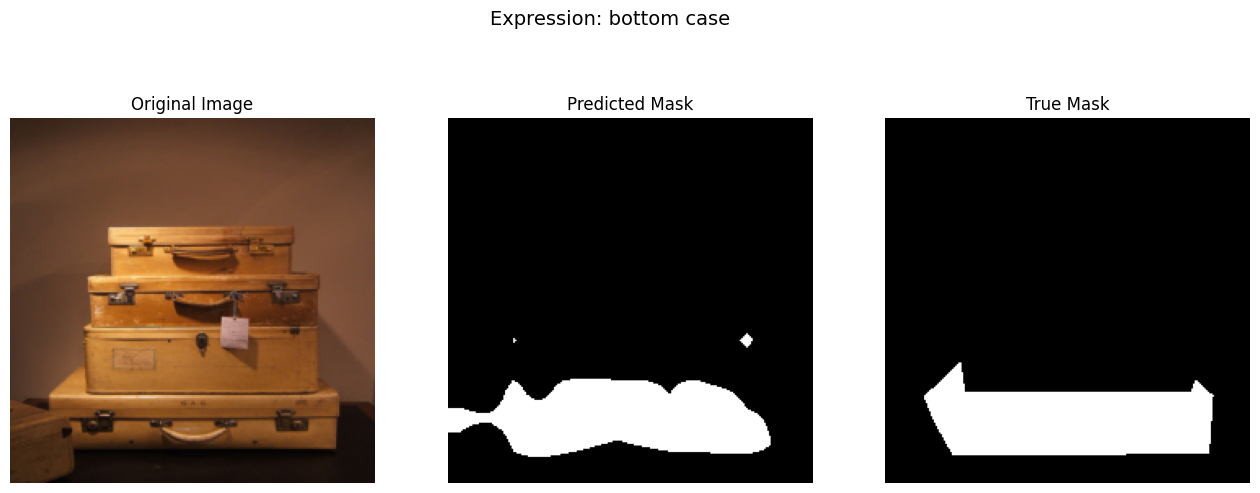

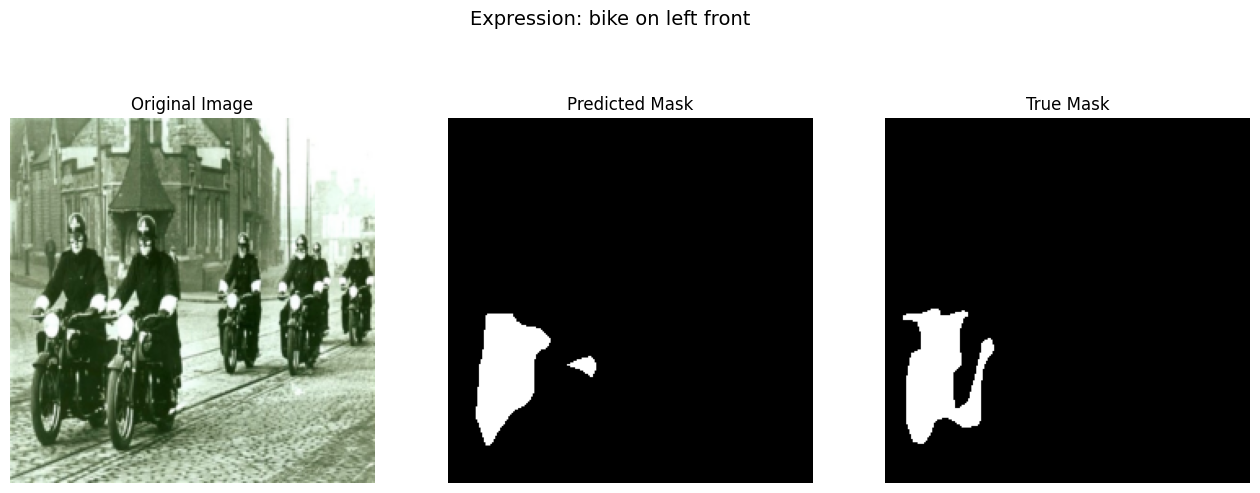

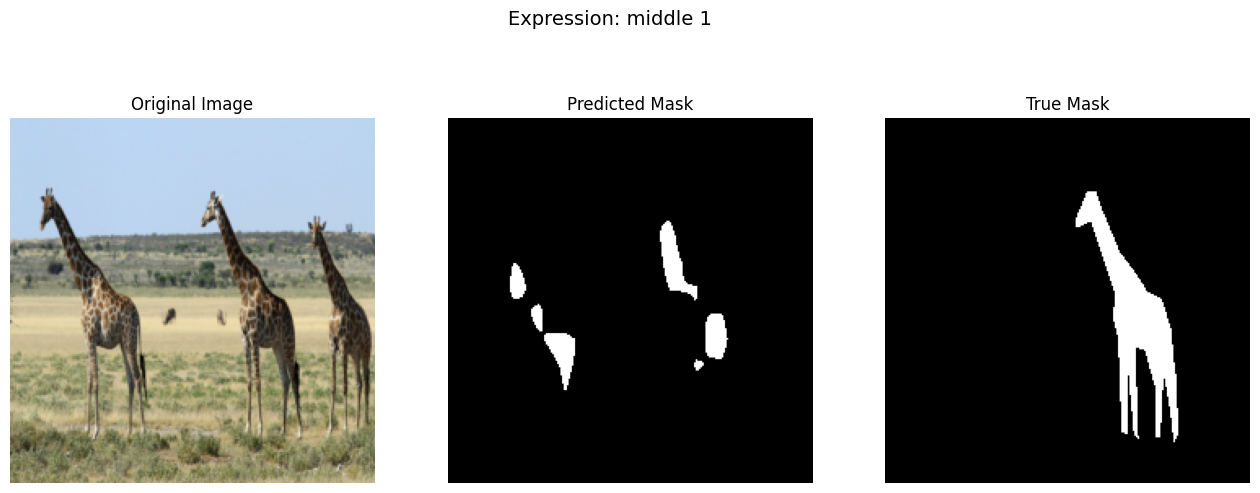

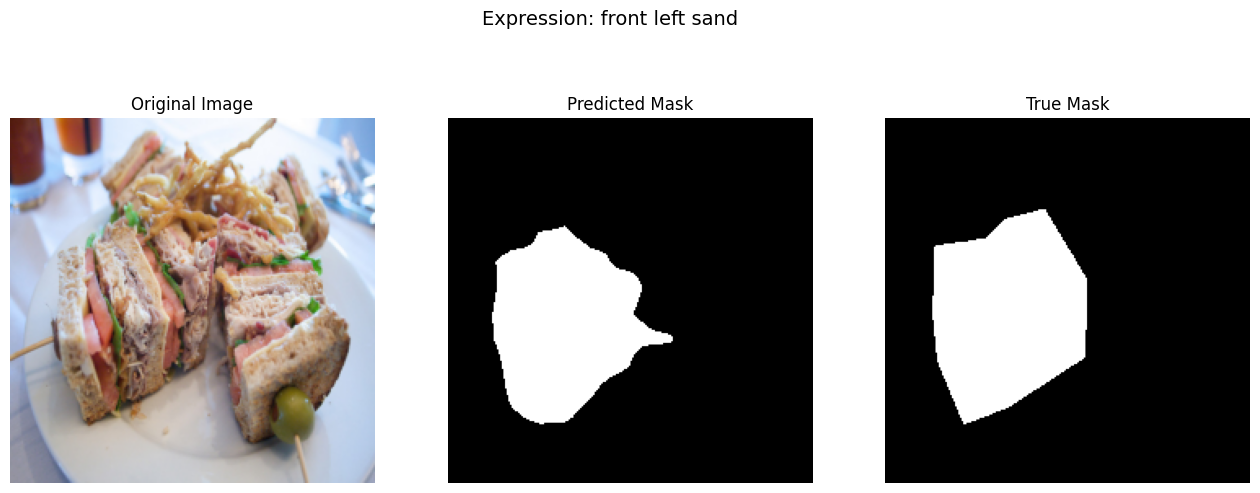

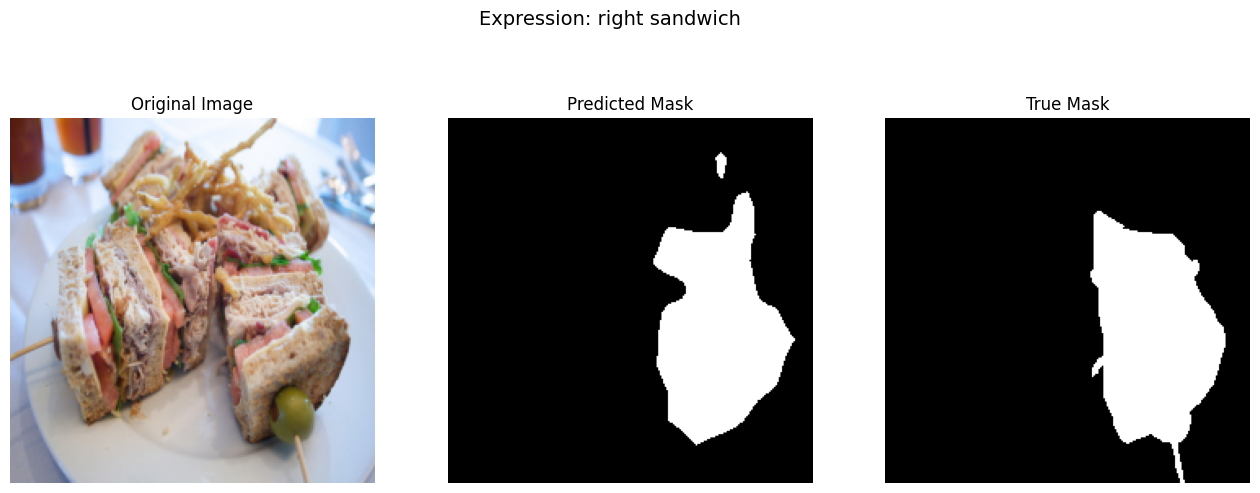

In [ ]:
import torch
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for images, expressions, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images, expressions)

        images_cpu = images.cpu()
        preds_cpu = (torch.sigmoid(preds) > 0.5).float().cpu()
        masks_cpu = masks.cpu()

        num_images_to_display = 5
        for i in range(min(num_images_to_display, images_cpu.size(0))):
            image = images_cpu[i].numpy().transpose(1, 2, 0)
            pred_mask = preds_cpu[i].numpy().squeeze()
            true_mask = masks_cpu[i].numpy().squeeze()
            expression = expressions[i]

            plt.figure(figsize=(16, 6))

            plt.suptitle(f"Expression: {expression}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask, cmap = 'gray')
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(true_mask, cmap = 'gray')
            plt.title("True Mask")
            plt.axis("off")

            plt.show()

        break

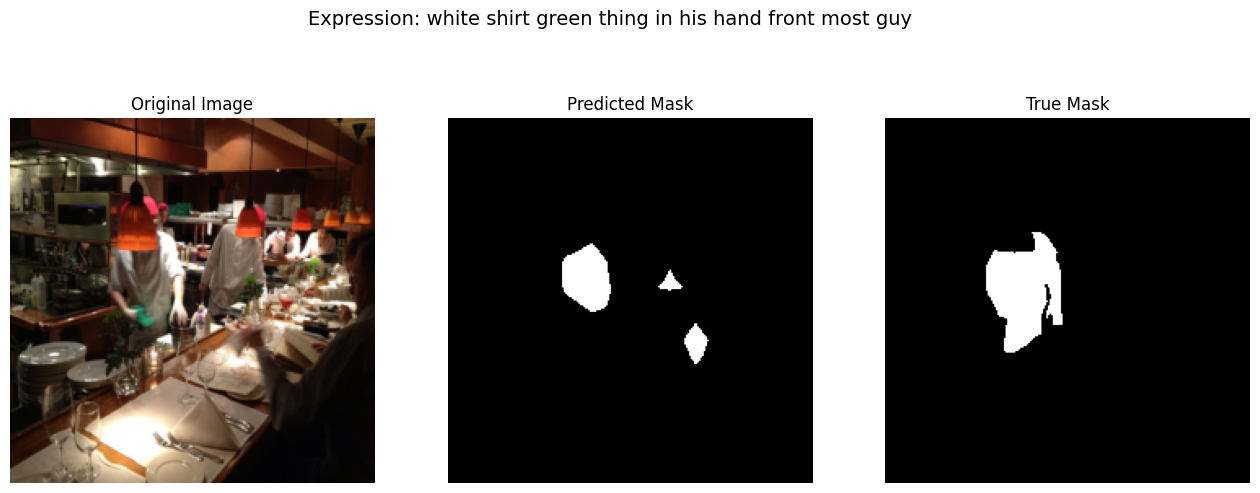

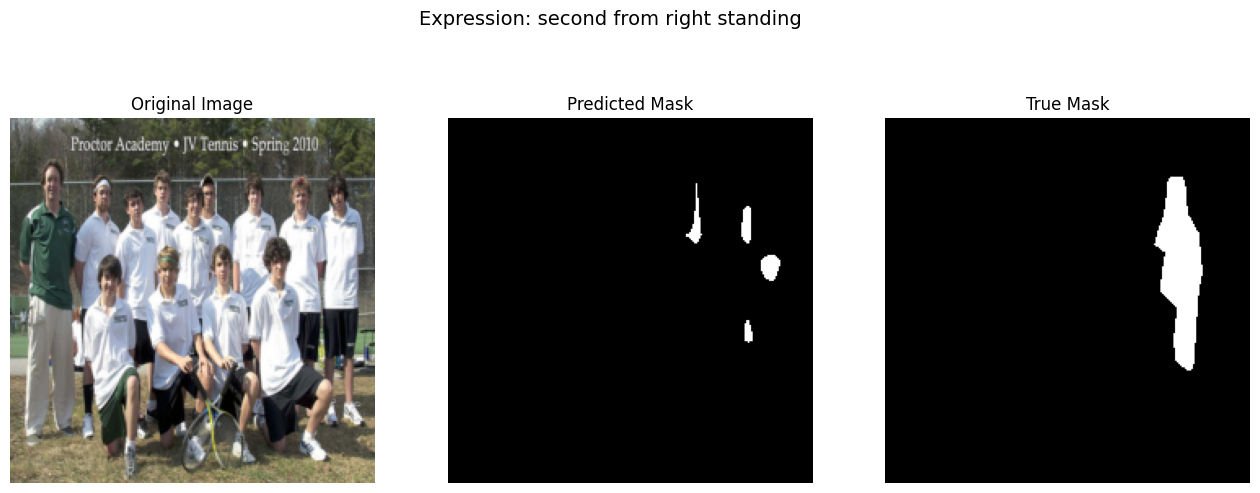

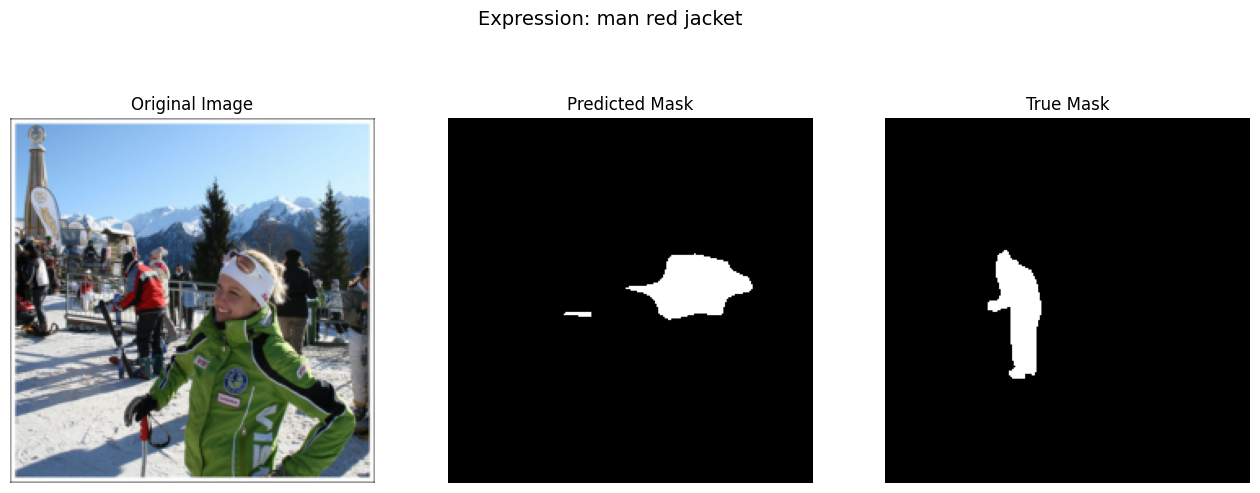

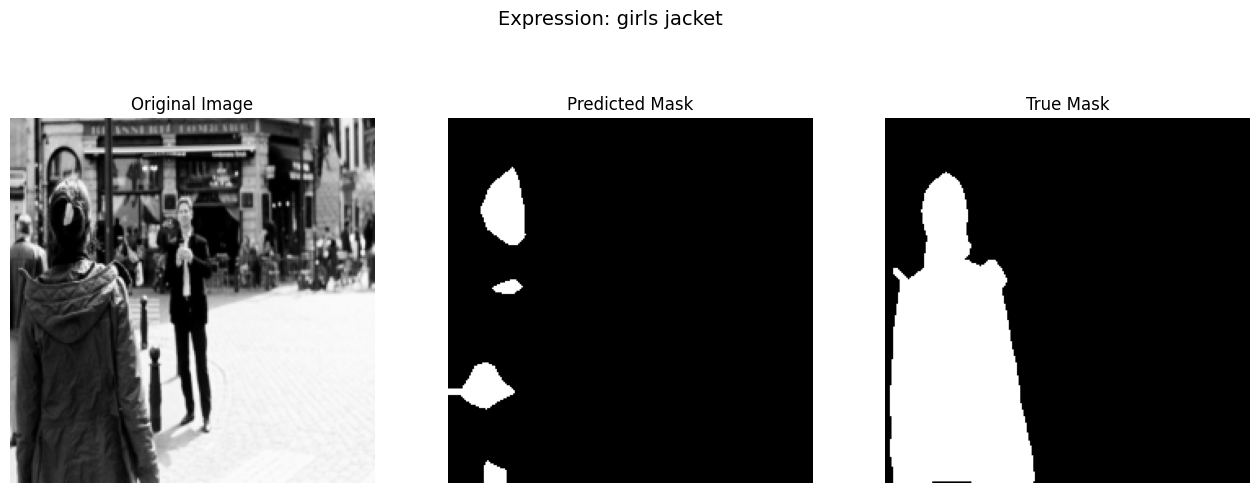

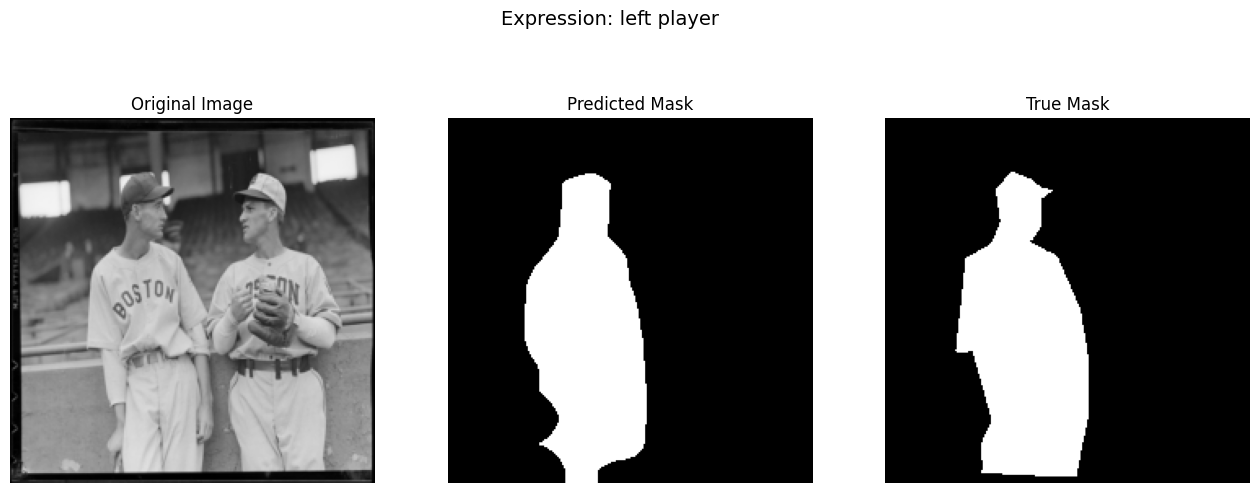

In [ ]:
import torch
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for images, expressions, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images, expressions)

        images_cpu = images.cpu()
        preds_cpu = (torch.sigmoid(preds) > 0.5).float().cpu()
        masks_cpu = masks.cpu()

        num_images_to_display = 5
        for i in range(min(num_images_to_display, images_cpu.size(0))):
            image = images_cpu[i].numpy().transpose(1, 2, 0)
            pred_mask = preds_cpu[i].numpy().squeeze()
            true_mask = masks_cpu[i].numpy().squeeze()
            expression = expressions[i]

            plt.figure(figsize=(16, 6))

            plt.suptitle(f"Expression: {expression}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask, cmap = 'gray')
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(true_mask, cmap = 'gray')
            plt.title("True Mask")
            plt.axis("off")

            plt.show()

        break

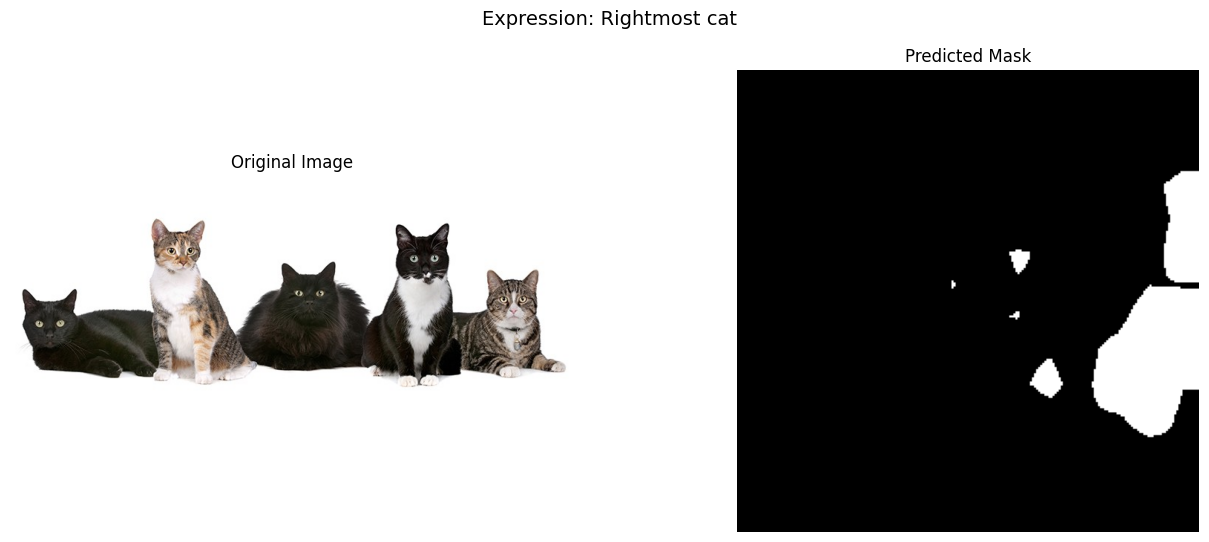

In [ ]:
import cv2

image_path = '/content/cats.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0

image = image.to(device).unsqueeze(0)

expression = "Rightmost cat"

model.eval()
with torch.no_grad():
    preds = model(image, expression)

images_cpu = image.cpu()
preds_cpu = (torch.sigmoid(preds) > 0.5).float().cpu()

image = images_cpu[0].numpy().transpose(1, 2, 0)
pred_mask = preds_cpu[0].numpy().squeeze()

plt.figure(figsize=(16, 6))
plt.suptitle(f"Expression: {expression}", fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/clip-seg-model.pth')

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': avg_loss,
    'train_dice_score': avg_dice_score,
    'val_loss': avg_val_loss,
    'val_dice_score': avg_val_dice_score,
}, '/content/drive/MyDrive/clip-seg-checkpoint.pth')